In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import re

In [4]:
#create sparksession
spark = SparkSession.builder.appName('ml').getOrCreate()

In [5]:
data1=spark.read.json("Toys_and_Games_5.json").select("reviewText","overall")
data2=spark.read.json("Sports_and_Outdoors_5.json").select("reviewText","overall")
data3=spark.read.json("Video_Games_5.json").select("reviewText","overall")

In [6]:
data4=data1.unionAll(data2).unionAll(data3)

In [7]:
proportion = data4.select("overall")\
         .groupBy("overall")\
         .count()\
         .toPandas()

In [8]:
proportion["count_normalized"] = proportion["count"]/sum(proportion["count"])

In [9]:
proportion = proportion.sort_values("overall").reset_index().drop('index', axis=1)
proportion

,overall,count,count_normalized
0,1.0,28605,0.041116
1,2.0,30165,0.043358
2,3.0,68703,0.098752
3,4.0,157058,0.225751
4,5.0,411183,0.591023


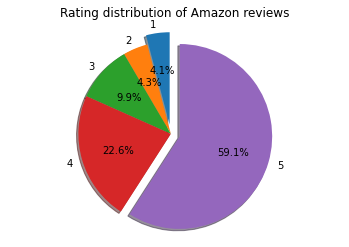

In [10]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '1', '2', '3', '4','5'
sizes = [0.041116, 0.043358, 0.098752,0.225751,0.591023]
explode = (0.1, 0, 0, 0,0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Rating distribution of Amazon reviews')
plt.show()

In [19]:
data5= data4.select("reviewText")

In [20]:
data5.show()

+--------------------+
|          reviewText|
+--------------------+
|I like the item p...|
|Love the magnet e...|
|Both sides are ma...|
|Bought one a few ...|
|I have a stainles...|
|this is a nice ma...|
|This is just as I...|
|My granddaughter ...|
|This is good prod...|
|I keep this board...|
|Very nice to use ...|
|Bought this board...|
|The board had to ...|
|sturdy and perfec...|
|We had purchased ...|
|We purchased this...|
|This easel is the...|
|This is my absolu...|
|Working with Mand...|
|This book contain...|
+--------------------+
only showing top 20 rows



In [21]:
def clean_data(text):
    content=str(text).lower()
    content=re.sub('[^a-z ]+', ' ',content)
    content=re.sub('\s+', ' ',content).strip()
    return content

In [22]:
clean_data_udf=udf(clean_data, StringType())
data5=data5.withColumn("reviewText_clean",clean_data_udf("reviewText"))

In [23]:
data5.select("reviewText_clean").show()

+--------------------+
|    reviewText_clean|
+--------------------+
|i like the item p...|
|love the magnet e...|
|both sides are ma...|
|bought one a few ...|
|i have a stainles...|
|this is a nice ma...|
|this is just as i...|
|my granddaughter ...|
|this is good prod...|
|i keep this board...|
|very nice to use ...|
|bought this board...|
|the board had to ...|
|sturdy and perfec...|
|we had purchased ...|
|we purchased this...|
|this easel is the...|
|this is my absolu...|
|working with mand...|
|this book contain...|
+--------------------+
only showing top 20 rows



In [25]:
#tokenizer
tokenizer = Tokenizer(inputCol="reviewText_clean", outputCol="words")
data5 = tokenizer.transform(data5)

In [26]:
data5.show()

+--------------------+--------------------+--------------------+
|          reviewText|    reviewText_clean|               words|
+--------------------+--------------------+--------------------+
|I like the item p...|i like the item p...|[i, like, the, it...|
|Love the magnet e...|love the magnet e...|[love, the, magne...|
|Both sides are ma...|both sides are ma...|[both, sides, are...|
|Bought one a few ...|bought one a few ...|[bought, one, a, ...|
|I have a stainles...|i have a stainles...|[i, have, a, stai...|
|this is a nice ma...|this is a nice ma...|[this, is, a, nic...|
|This is just as I...|this is just as i...|[this, is, just, ...|
|My granddaughter ...|my granddaughter ...|[my, granddaughte...|
|This is good prod...|this is good prod...|[this, is, good, ...|
|I keep this board...|i keep this board...|[i, keep, this, b...|
|Very nice to use ...|very nice to use ...|[very, nice, to, ...|
|Bought this board...|bought this board...|[bought, this, bo...|
|The board had to ...|the

In [27]:
swr = StopWordsRemover(inputCol = 'words', outputCol = 'words_sw_removed')
data5 = swr.transform(data5)

In [28]:
data5.show()

+--------------------+--------------------+--------------------+--------------------+
|          reviewText|    reviewText_clean|               words|    words_sw_removed|
+--------------------+--------------------+--------------------+--------------------+
|I like the item p...|i like the item p...|[i, like, the, it...|[like, item, pric...|
|Love the magnet e...|love the magnet e...|[love, the, magne...|[love, magnet, ea...|
|Both sides are ma...|both sides are ma...|[both, sides, are...|[sides, magnetic,...|
|Bought one a few ...|bought one a few ...|[bought, one, a, ...|[bought, one, yea...|
|I have a stainles...|i have a stainles...|[i, have, a, stai...|[stainless, steel...|
|this is a nice ma...|this is a nice ma...|[this, is, a, nic...|[nice, magnetic, ...|
|This is just as I...|this is just as i...|[this, is, just, ...|[expected, sturdy...|
|My granddaughter ...|my granddaughter ...|[my, granddaughte...|[granddaughter, r...|
|This is good prod...|this is good prod...|[this, is, 

In [29]:
data5.select("words_sw_removed").show()

+--------------------+
|    words_sw_removed|
+--------------------+
|[like, item, pric...|
|[love, magnet, ea...|
|[sides, magnetic,...|
|[bought, one, yea...|
|[stainless, steel...|
|[nice, magnetic, ...|
|[expected, sturdy...|
|[granddaughter, r...|
|[good, product, u...|
|[keep, board, top...|
|[nice, use, magne...|
|[bought, board, a...|
|[board, put, away...|
|[sturdy, perfect,...|
|[purchased, melis...|
|[purchased, go, m...|
|[easel, perfect, ...|
|[absolute, favori...|
|[working, mandala...|
|[book, contains, ...|
+--------------------+
only showing top 20 rows



In [88]:
data5.select("words").rdd.flatMap(lambda x:x[0]).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a+b).sortBy(lambda x: x[1], False).take(20)

[('the', 866568),
 ('and', 519341),
 ('it', 463592),
 ('a', 444148),
 ('to', 441953),
 ('i', 332409),
 ('is', 300496),
 ('of', 271461),
 ('this', 267971),
 ('for', 252381),
 ('with', 196603),
 ('that', 183170),
 ('my', 179061),
 ('in', 163249),
 ('you', 139550),
 ('are', 128585),
 ('but', 127703),
 ('on', 125047),
 ('s', 122505),
 ('have', 107730)]